## Bibliotecas utilizadas

In [121]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

## Importando o dataset
* Antes importar o dataset, o arquivo original foi alterado, retirando os caracteres especiais

In [112]:
df = pd.read_csv("dataset_teste_selecao.csv")
df.head()

,paciente_id,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,...,idade,cor_autorreferida,estado_civil,escolaridade,tipo_caso_a_admissao,tempo_sintomas_internacao,desfecho,obito_menos24horas,obito_vm,obito_uti
0,e5841df2166dd424a57127423d276bbe,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,...,76.0,Parda/mulata,Casado/ amasiado,Ensino fundamental incompleto(1G),Caso suspeito,NaN,obito,Nao,Sim,Sim
1,3c59dc048e8850243be8079a5c74d079,Nao,Sim,Nao,Sim,Sim,Nao,Nao,Sim,Nao,...,33.0,Nao informado,Nao informado,Nao informado,Caso suspeito,7.0,alta,NaN,NaN,NaN
2,99c5e07b4d5de9d18c350cdf64c5aa3d,Nao,Nao,Nao,Sim,Sim,Nao,Nao,Nao,Nao,...,42.0,Amarela/Oriental,Casado/ amasiado,Ensino medio completo,Caso suspeito,10.0,alta,NaN,NaN,NaN
3,1587965fb4d4b5afe8428a4a024feb0d,Nao,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,...,64.0,Branca,Casado/ amasiado,Ensino fundamental incompleto(1G),Caso suspeito,11.0,obito,Nao,Sim,Sim
4,b4a528955b84f584974e92d025a75d1f,Nao,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,...,73.0,Parda/mulata,Casado/ amasiado,Ensino fundamental incompleto(1G),Caso suspeito,7.0,obito,Nao,Sim,Sim


## Correlação entre váriaveis e gráficos
* Foram utilizadas colunas relacionadas ao tempo, e a coluna de idade do paciente
* Com os gráficos é possível análisar como está distribuido as informações acima 

In [113]:
df2 = pd.DataFrame()
df2[['idade','tempo_vmi_total', 'tempo_uti_total', 'tempo_internacao', 'tempo_referencia_internacao', 'tempo_sintomas_internacao']] = df[['idade','tempo_vmi_total', 'tempo_uti_total', 'tempo_internacao', 'tempo_referencia_internacao', 'tempo_sintomas_internacao']]
df2.head()

,idade,tempo_vmi_total,tempo_uti_total,tempo_internacao,tempo_referencia_internacao,tempo_sintomas_internacao
0,76.0,15.0,11.0,11.0,4.0,NaN
1,33.0,29.0,32.0,37.0,3.0,7.0
2,42.0,28.0,31.0,37.0,4.0,10.0
3,64.0,40.0,34.0,34.0,1.0,11.0
4,73.0,12.0,21.0,33.0,0.0,7.0


<AxesSubplot:>

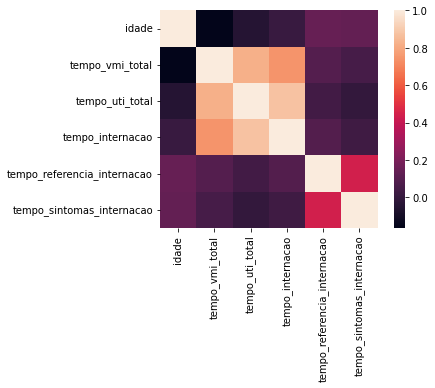

In [114]:
#separar variáveis em novos quadros de dados
numeric_df = df2.select_dtypes(include=[np.number])
#grafico de correlação
corr = numeric_df.corr()
sns.heatmap(corr, square=True)

/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

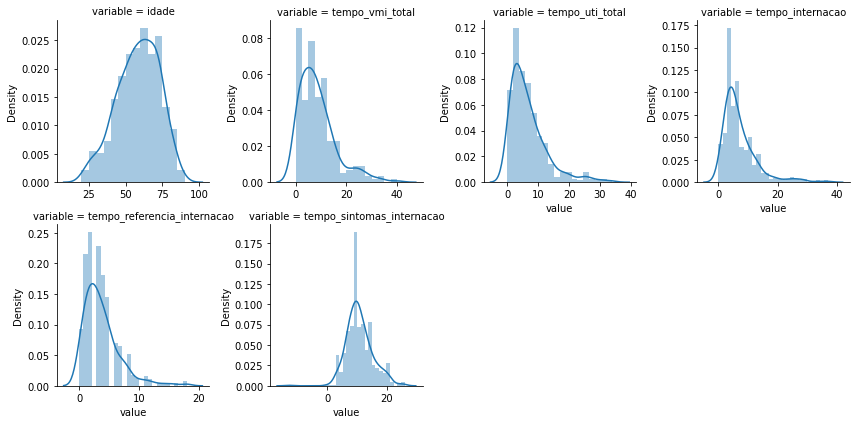

In [115]:
#criação dos graficos
num = [f for f in df2.columns if df2.dtypes[f] != 'object']
nd = pd.melt(df2, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

## Classificação Sintomas x Bairro
* Foi utilizado apenas as colunas dos sintomas e do bairro formando um novo dataframe
* Foi alterado as colunas de sintomas utilizando o valor 1 para "SIM" e o valor 0 para "NAO"
* Foram apagado as linhas cujo os valores do bairro eram vazios
#### Obs1: A metodologia escolhida para a organização dos códigos, não é a mais eficiente, mas a que considerei mais organizada e de fácil compreensão.
#### Obs2: Essa classificação tem como objetivo identificar padrões dos sintomas por bairro, como o dataset é apenas um recorte os resultados não foram bons, talvez o dataset completo referente aos bairros de fortaleza, poderia-se obter resultados melhores.
#### Obs3: Foram utilizados os classificadores Knn e SVM

In [116]:
df3 = pd.DataFrame()
df3[['coriza','tosse_seca_ou_produtiva','calafrios','febre','dispneia','fadiga','anorexia','mialgia','astenia','dor_de_garganta','congestao_nasal','cefaleia','diarreia','nausea','vomitos','anosmia','ageusia', 'bairro']] = df[['coriza','tosse_seca_ou_produtiva','calafrios','febre','dispneia','fadiga','anorexia','mialgia','astenia','dor_de_garganta','congestao_nasal','cefaleia','diarreia','nausea','vomitos','anosmia','ageusia', 'bairro']]
df3.head()

,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,bairro
0,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,NaN
1,Nao,Sim,Nao,Sim,Sim,Nao,Nao,Sim,Nao,Sim,Nao,Nao,Sim,Nao,Nao,Nao,Nao,NaN
2,Nao,Nao,Nao,Sim,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,NaN
3,Nao,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,NaN
4,Nao,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,NaN


In [117]:
df3['coriza'] = df3['coriza'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['tosse_seca_ou_produtiva'] = df3['tosse_seca_ou_produtiva'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['calafrios'] = df3['calafrios'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['febre'] = df3['febre'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['dispneia'] = df3['dispneia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['fadiga'] = df3['fadiga'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['anorexia'] = df3['anorexia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['mialgia'] = df3['mialgia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['astenia'] = df3['astenia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['dor_de_garganta'] = df3['dor_de_garganta'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['congestao_nasal'] = df3['congestao_nasal'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['cefaleia'] = df3['cefaleia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['diarreia'] = df3['diarreia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['nausea'] = df3['nausea'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['vomitos'] = df3['vomitos'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['anosmia'] = df3['anosmia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3['ageusia'] = df3['ageusia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df3.head()

,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,bairro
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,NaN
2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [118]:
df3 = df3[df3['bairro'].notna()]
df3.head()

,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,bairro
5,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,Canindezinho
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Genibau
7,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,Centro
9,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Jangurussu
10,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,Mondubim


In [119]:
X = df3[['coriza','tosse_seca_ou_produtiva','calafrios','febre','dispneia','fadiga','anorexia','mialgia','astenia','dor_de_garganta','congestao_nasal','cefaleia','diarreia','nausea','vomitos','anosmia','ageusia']]
y = df3['bairro']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [124]:
#SVM
x = SVC(kernel="linear")
x.fit(X_train, y_train)
y_pred = x.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  3.36%


In [126]:
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

              Aerolandia       0.00      0.00      0.00         1
                 Aldeota       0.00      0.00      0.00         1
         Antonio Bezerra       0.00      0.00      0.00         0
            Autran Nunes       0.00      0.00      0.00         2
          Barra do Ceara       0.00      0.00      0.00         1
                 Barroso       0.00      0.00      0.00         2
              Bela Vista       0.00      0.00      0.00         2
               Boa Vista       0.00      0.00      0.00         1
              Bom Jardim       0.00      0.00      0.00         3
              Bonsucesso       0.20      0.33      0.25         3
           Cais do Porto       0.00      0.00      0.00         2
                 Cambeba       0.00      0.00      0.00         1
            Canindezinho       0.00      0.00      0.00         2
        Carlito Pamplona       0.00      0.00      0.00         2
       Ca

/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap

In [125]:
#usando a métrica euclidiana
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(X_train, y_train)

Knn_pred = knn.predict(X_test)
accuracy_score(y_test, Knn_pred)
ac = accuracy_score(y_test, Knn_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  1.34%


In [127]:
print(classification_report(y_test, Knn_pred))

                          precision    recall  f1-score   support

              Aerolandia       0.00      0.00      0.00         1
                 Aldeota       0.00      0.00      0.00         1
                  Ancuri       0.00      0.00      0.00         0
         Antonio Bezerra       0.00      0.00      0.00         0
            Autran Nunes       0.00      0.00      0.00         2
          Barra do Ceara       0.00      0.00      0.00         1
                 Barroso       0.00      0.00      0.00         2
              Bela Vista       0.00      0.00      0.00         2
               Boa Vista       0.00      0.00      0.00         1
              Bom Jardim       0.00      0.00      0.00         3
              Bonsucesso       0.00      0.00      0.00         3
           Cais do Porto       0.00      0.00      0.00         2
                 Cambeba       0.00      0.00      0.00         1
            Canindezinho       0.00      0.00      0.00         2
        C

/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap

In [128]:
print(confusion_matrix(y_test, Knn_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Classificação Histórico pessoal x desfecho
* Utilizada a mesma abordagem da classificação anterior, alterando apenas as colunas
* Os resultados foram bem melhores, com o intuito de saber a relação entre o desfecho do paciente caso ele seja usuário algum tipo de droga licita, ou ilicita.

In [129]:
df4 = pd.DataFrame()
df4[['tabagismo','drogas','etilismo', 'desfecho']] = df[['tabagismo','drogas','etilismo', 'desfecho']]
df4.head()

,tabagismo,drogas,etilismo,desfecho
0,Nao,Nao,Nao,obito
1,Nao,Sim,Nao,alta
2,Nao,Nao,Nao,alta
3,Nao,Nao,Nao,obito
4,Nao,Nao,Nao,obito


In [130]:
df4['tabagismo'] = df4['tabagismo'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df4['drogas'] = df4['drogas'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df4['etilismo'] = df4['etilismo'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df4.head()

,tabagismo,drogas,etilismo,desfecho
0,0,0,0,obito
1,0,1,0,alta
2,0,0,0,alta
3,0,0,0,obito
4,0,0,0,obito


In [131]:
df4 = df4[df4['desfecho'].notna()]
df4.head()

,tabagismo,drogas,etilismo,desfecho
0,0,0,0,obito
1,0,1,0,alta
2,0,0,0,alta
3,0,0,0,obito
4,0,0,0,obito


In [132]:
X = df4[['tabagismo','drogas','etilismo']]
y = df4['desfecho']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [133]:
#SVM
x = SVC(kernel="linear")
x.fit(X_train, y_train)
y_pred = x.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  57.66%


In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        alta       0.58      1.00      0.73       128
       obito       0.00      0.00      0.00        94

    accuracy                           0.58       222
   macro avg       0.29      0.50      0.37       222
weighted avg       0.33      0.58      0.42       222



/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
print(confusion_matrix(y_test, y_pred))

[[128   0]
 [ 94   0]]


In [137]:
#usando a métrica euclidiana
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(X_train, y_train)

Knn_pred = knn.predict(X_test)
ac = accuracy_score(y_test, Knn_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

0.42792792792792794

In [138]:
print(classification_report(y_test, Knn_pred))

              precision    recall  f1-score   support

        alta       1.00      0.01      0.02       128
       obito       0.43      1.00      0.60        94

    accuracy                           0.43       222
   macro avg       0.71      0.50      0.31       222
weighted avg       0.76      0.43      0.26       222



In [139]:
print(confusion_matrix(y_test, Knn_pred))

[[  1 127]
 [  0  94]]


## Classificação Sintomas x Tipo_caso_a_admissao
* A partir dos sintomas classificar se o paciente é suspeito ou não

In [140]:
df5 = pd.DataFrame()
df5[['coriza','tosse_seca_ou_produtiva','calafrios','febre','dispneia','fadiga','anorexia','mialgia','astenia','dor_de_garganta','congestao_nasal','cefaleia','diarreia','nausea','vomitos','anosmia','ageusia', 'tipo_caso_a_admissao']] = df[['coriza','tosse_seca_ou_produtiva','calafrios','febre','dispneia','fadiga','anorexia','mialgia','astenia','dor_de_garganta','congestao_nasal','cefaleia','diarreia','nausea','vomitos','anosmia','ageusia', 'tipo_caso_a_admissao']]
df5.head()

,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,tipo_caso_a_admissao
0,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Caso suspeito
1,Nao,Sim,Nao,Sim,Sim,Nao,Nao,Sim,Nao,Sim,Nao,Nao,Sim,Nao,Nao,Nao,Nao,Caso suspeito
2,Nao,Nao,Nao,Sim,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Caso suspeito
3,Nao,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Caso suspeito
4,Nao,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Caso suspeito


In [141]:
df5['coriza'] = df5['coriza'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['tosse_seca_ou_produtiva'] = df5['tosse_seca_ou_produtiva'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['calafrios'] = df5['calafrios'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['febre'] = df5['febre'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['dispneia'] = df5['dispneia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['fadiga'] = df5['fadiga'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['anorexia'] = df5['anorexia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['mialgia'] = df5['mialgia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['astenia'] = df5['astenia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['dor_de_garganta'] = df5['dor_de_garganta'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['congestao_nasal'] = df5['congestao_nasal'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['cefaleia'] = df5['cefaleia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['diarreia'] = df5['diarreia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['nausea'] = df5['nausea'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['vomitos'] = df5['vomitos'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['anosmia'] = df5['anosmia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5['ageusia'] = df5['ageusia'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df5.head()

,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,tipo_caso_a_admissao
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito
1,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,Caso suspeito
2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito


In [142]:
df5 = df5[df5['tipo_caso_a_admissao'].notna()]
df5.head()

,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,tipo_caso_a_admissao
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito
1,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,Caso suspeito
2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Caso suspeito


In [143]:
X = df5[['coriza','tosse_seca_ou_produtiva','calafrios','febre','dispneia','fadiga','anorexia','mialgia','astenia','dor_de_garganta','congestao_nasal','cefaleia','diarreia','nausea','vomitos','anosmia','ageusia']]
y = df5['tipo_caso_a_admissao']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [144]:
#SVM
x = SVC(kernel="linear")
x.fit(X_train, y_train)
y_pred = x.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  65.22%


In [145]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

Caso confirmado       0.67      0.05      0.09        82
  Caso suspeito       0.65      0.99      0.78       148

       accuracy                           0.65       230
      macro avg       0.66      0.52      0.44       230
   weighted avg       0.66      0.65      0.54       230



In [146]:
print(confusion_matrix(y_test, y_pred))

[[  4  78]
 [  2 146]]


In [147]:
#usando a métrica euclidiana
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(X_train, y_train)

Knn_pred = knn.predict(X_test)
ac = accuracy_score(y_test, Knn_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  64.78%


In [148]:
print(classification_report(y_test, Knn_pred))

                 precision    recall  f1-score   support

Caso confirmado       1.00      0.01      0.02        82
  Caso suspeito       0.65      1.00      0.79       148

       accuracy                           0.65       230
      macro avg       0.82      0.51      0.40       230
   weighted avg       0.77      0.65      0.51       230



In [149]:
print(confusion_matrix(y_test, Knn_pred))

[[  1  81]
 [  0 148]]


## Classificação Comorbidade x Desfecho
* Análise do impacto da comorbidade no desfecho do paciente

In [150]:
df6 = pd.DataFrame()
df6[['diabetes','obesidade','hipertensao_arterial','doenca_cardiaca','doenca_pulmonar','doenca_reumatologica','doenca_autoimune','doenca_renal_cronica','doenca_hepatica_cronica','doenca_neurologica', 'desfecho']] = df[['diabetes','obesidade','hipertensao_arterial','doenca_cardiaca','doenca_pulmonar','doenca_reumatologica','doenca_autoimune','doenca_renal_cronica','doenca_hepatica_cronica','doenca_neurologica', 'desfecho']]
df6.head()

,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,desfecho
0,Nao,Nao,Sim,Sim,Nao,Sim,Nao,Nao,Nao,Nao,obito
1,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,alta
2,Nao,Sim,Sim,Nao,Sim,Nao,Nao,Nao,Nao,Nao,alta
3,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,obito
4,Sim,Nao,Sim,Sim,Nao,Nao,Nao,Nao,Nao,Sim,obito


In [151]:
df6['diabetes'] = df6['diabetes'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['obesidade'] = df6['obesidade'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['hipertensao_arterial'] = df6['hipertensao_arterial'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['doenca_cardiaca'] = df6['doenca_cardiaca'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['doenca_pulmonar'] = df6['doenca_pulmonar'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['doenca_reumatologica'] = df6['doenca_reumatologica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['doenca_autoimune'] = df6['doenca_autoimune'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['doenca_renal_cronica'] = df6['doenca_renal_cronica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['doenca_hepatica_cronica'] = df6['doenca_hepatica_cronica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6['doenca_neurologica'] = df6['doenca_neurologica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df6.head()

,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,desfecho
0,0,0,1,1,0,1,0,0,0,0,obito
1,0,0,0,0,0,0,0,0,0,0,alta
2,0,1,1,0,1,0,0,0,0,0,alta
3,0,0,0,0,0,0,0,0,0,0,obito
4,1,0,1,1,0,0,0,0,0,1,obito


In [152]:
df6 = df6[df6['desfecho'].notna()]
df6.head()

,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,desfecho
0,0,0,1,1,0,1,0,0,0,0,obito
1,0,0,0,0,0,0,0,0,0,0,alta
2,0,1,1,0,1,0,0,0,0,0,alta
3,0,0,0,0,0,0,0,0,0,0,obito
4,1,0,1,1,0,0,0,0,0,1,obito


In [153]:
X = df6[['diabetes','obesidade','hipertensao_arterial','doenca_cardiaca','doenca_pulmonar','doenca_reumatologica','doenca_autoimune','doenca_renal_cronica','doenca_hepatica_cronica','doenca_neurologica']]
y = df6['desfecho']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [154]:
#SVM
x = SVC(kernel="linear")
x.fit(X_train, y_train)
y_pred = x.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  57.21%


In [155]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        alta       0.58      0.91      0.71       128
       obito       0.48      0.11      0.17        94

    accuracy                           0.57       222
   macro avg       0.53      0.51      0.44       222
weighted avg       0.54      0.57      0.48       222



In [156]:
print(confusion_matrix(y_test, y_pred))

[[117  11]
 [ 84  10]]


In [157]:
#usando a métrica euclidiana
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(X_train, y_train)

Knn_pred = knn.predict(X_test)
ac = accuracy_score(y_test, Knn_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  57.21%


In [158]:
print(classification_report(y_test, Knn_pred))

              precision    recall  f1-score   support

        alta       0.58      0.98      0.73       128
       obito       0.33      0.01      0.02        94

    accuracy                           0.57       222
   macro avg       0.45      0.50      0.37       222
weighted avg       0.47      0.57      0.43       222



In [159]:
print(confusion_matrix(y_test, Knn_pred))

[[126   2]
 [ 93   1]]


## Classificação Comorbidade x UTI
* Análise do impacto da comorbidade na utilização da UTI pelo paciente

In [160]:
df7 = pd.DataFrame()
df7[['diabetes','obesidade','hipertensao_arterial','doenca_cardiaca','doenca_pulmonar','doenca_reumatologica','doenca_autoimune','doenca_renal_cronica','doenca_hepatica_cronica','doenca_neurologica', 'uti']] = df[['diabetes','obesidade','hipertensao_arterial','doenca_cardiaca','doenca_pulmonar','doenca_reumatologica','doenca_autoimune','doenca_renal_cronica','doenca_hepatica_cronica','doenca_neurologica', 'uti']]
df7.head()

,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,uti
0,Nao,Nao,Sim,Sim,Nao,Sim,Nao,Nao,Nao,Nao,Sim
1,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Sim
2,Nao,Sim,Sim,Nao,Sim,Nao,Nao,Nao,Nao,Nao,Sim
3,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Nao,Sim
4,Sim,Nao,Sim,Sim,Nao,Nao,Nao,Nao,Nao,Sim,Sim


In [161]:
df7['diabetes'] = df7['diabetes'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['obesidade'] = df7['obesidade'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['hipertensao_arterial'] = df7['hipertensao_arterial'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['doenca_cardiaca'] = df7['doenca_cardiaca'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['doenca_pulmonar'] = df7['doenca_pulmonar'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['doenca_reumatologica'] = df7['doenca_reumatologica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['doenca_autoimune'] = df7['doenca_autoimune'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['doenca_renal_cronica'] = df7['doenca_renal_cronica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['doenca_hepatica_cronica'] = df7['doenca_hepatica_cronica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7['doenca_neurologica'] = df7['doenca_neurologica'].map({'Sim':'1', 'Nao':'0'}, na_action='ignore')
df7.head()

,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,uti
0,0,0,1,1,0,1,0,0,0,0,Sim
1,0,0,0,0,0,0,0,0,0,0,Sim
2,0,1,1,0,1,0,0,0,0,0,Sim
3,0,0,0,0,0,0,0,0,0,0,Sim
4,1,0,1,1,0,0,0,0,0,1,Sim


In [162]:
df7 = df7[df7['uti'].notna()]
df7.head()

,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,uti
0,0,0,1,1,0,1,0,0,0,0,Sim
1,0,0,0,0,0,0,0,0,0,0,Sim
2,0,1,1,0,1,0,0,0,0,0,Sim
3,0,0,0,0,0,0,0,0,0,0,Sim
4,1,0,1,1,0,0,0,0,0,1,Sim


In [163]:
X = df7[['diabetes','obesidade','hipertensao_arterial','doenca_cardiaca','doenca_pulmonar','doenca_reumatologica','doenca_autoimune','doenca_renal_cronica','doenca_hepatica_cronica','doenca_neurologica']]
y = df7['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [164]:
#SVM
x = SVC(kernel="linear")
x.fit(X_train, y_train)
y_pred = x.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  67.1%


In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Nao       0.00      0.00      0.00        76
         Sim       0.67      1.00      0.80       155

    accuracy                           0.67       231
   macro avg       0.34      0.50      0.40       231
weighted avg       0.45      0.67      0.54       231



/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
print(confusion_matrix(y_test, y_pred))

[[  0  76]
 [  0 155]]


In [167]:
#usando a métrica euclidiana
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(X_train, y_train)

Knn_pred = knn.predict(X_test)
ac = accuracy_score(y_test, Knn_pred)
print("Acurácia: ", str(round(ac*100, 2)) + "%")

Acurácia:  67.1%


In [168]:
print(classification_report(y_test, Knn_pred))

              precision    recall  f1-score   support

         Nao       0.00      0.00      0.00        76
         Sim       0.67      1.00      0.80       155

    accuracy                           0.67       231
   macro avg       0.34      0.50      0.40       231
weighted avg       0.45      0.67      0.54       231



/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hugo/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [169]:
print(confusion_matrix(y_test, Knn_pred))

[[  0  76]
 [  0 155]]
